In [1]:
%matplotlib inline
import sys
import copy
import collections
sys.path.append("../../")
from QUEEN.queen import *
set_namespace(globals()) 
if "output" not in os.listdir("./"):
    os.mkdir("output")

In [2]:
#Extract LUT region
LUT = cropdna(QUEEN(record="input/addgene_87554_attachment.gbk"), 2794, 10915)
LUT.writedna("output/LUT.gbk", record_id="Boolean_Logic_LUT")
LUT = QUEEN(record="output/LUT.gbk", import_history=False)

In [3]:
#Setting for visualization of the genetic Boolean LUT
feat_labels = ["FRT", "loxP", "lox2272", "GFP1", "GFP2", "GFP3", "GFP4", "attB\(PhiC31\)", "attP\(PhiC31\)", "vox","B3RT", "attB\(Bxb1\)", "attP\(Bxb1\)", 
               "NeoR1", "NeoR2", "pA"]
colors      = [('#30458e', '#30458e'), ('#e41a1c', '#e41a1c'), ('#8600d4', '#8600d4'), ('#006400', '#006400'), ('#006400', '#006400'), ('#006400', '#006400'), 
               ('#006400', '#006400'), ('#c71585', '#c71585'), ('#ffa1d2', '#ffa1d2'), ('#21a0db', '#21a0db'), ('#b5b521', '#b5b521'), ('#a65628', '#a65628'), 
               ('#e3b85f', '#e3b85f'), ('#0d6fbd', '#ddefef'), ('#0d6fbd', '#ddefef'), ('#909090', '#eeeeee')]
feat_labels = [".*{}".format(label) for label in feat_labels]
for color_pair, label in zip(colors, feat_labels):
    editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:edgecolor_queen",   operation=createattribute(color_pair[0]), new_copy=False)
    editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:facecolor_queen",   operation=createattribute(color_pair[0]), new_copy=False)
    if "GFP" in label:
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#CCCCCC"), new_copy=False)
    else:
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#FFFFFF"), new_copy=False)
    editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelweight_queen", operation=createattribute("bold"), new_copy=False)

feature_id  feature_type  qualifier:label  start  end   strand  
1           misc_feature  FRT              0      34    +       
1800        misc_feature  FRT              4086   4120  +       
1900        misc_feature  loxP             4121   4155  +       
2700        misc_feature  loxP             6712   6746  +       
200         misc_feature  lox2272          35     69    +       
1000        misc_feature  lox2272          1493   1527  +       
600         CDS           GFP1             658    1378  -       
1500        CDS           GFP2             2769   3489  +       
2400        CDS           GFP3             5395   6115  +       
3100        CDS           GFP4             7339   8059  -       
300         misc_feature  attB(PhiC31)     75     121   +       
700         misc_feature  attP(PhiC31)     1387   1433  -       
1100        misc_feature  vox              1533   1567  +       
1400        misc_feature  vox              2726   2760  +       
2000        misc_feature 

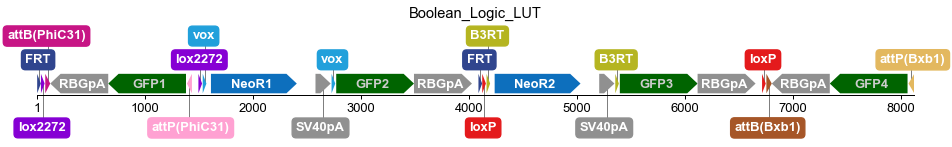

In [4]:
features = sum([LUT.searchfeature(query=label, key_attribute="qualifier:label") for label in feat_labels],[])
LUT.printfeature(feature_list=features)
fig = visualizedna(LUT, feature_list=features, label_location='both', fontsize=13, tick_space=1000, label_visible=2, width_scale=0.5, height_scale=1.1, labelcolor="w")
fig.savefig("LUT.pdf", bbox_inches="tight")

In [5]:
from QUEEN import cutsite as cs 
cs.lib["attB_PhiC31"] = "GTGCGGGTGCCAGGGCGTGCCC^TT_GGGCTCCCCGGGCGCGTACTCC"
cs.lib["attP_PhiC31"] = "ACGCCCCCAACTGAGAGAACTC^AA_AGGTTACCCCAGTTGGGGCACT"
cs.lib["attB_Bxb1"]   = "TCGGCCGGCTTGTCGACGACGGCG^GT_CTCCGTCGTCAGGATCATCCGGGC"
cs.lib["attP_Bxb1"]   = "GGGTTTGTACCGTACACCACTGAG^AC_CGCGGTGGTTGACCAGACAAACCACGA"
cs.lib["vox"]         = "AATAGGTCTGAGAA^CGCCCA_TTCTCAGACGTATT"
cs.lib["B3RT"]        = "GGTTGCTTAAGAAT^AAGTA_ATTCTTAAGCAACC"
cs.lib["loxP"]        = "ATAACTTCGTATAA^TGTATG_CTATACGAAGTTAT"
cs.lib["lox2272"]     = "ATAACTTCGTATAA^AGTATC_CTATACGAAGTTAT"
cs.lib["FRT"]         = "GAAGTTCCTATTC^TCTAGAAA_GTATAGGAACTTC"

In [6]:
#Configure a logic gate from the genetic Boolean LUT
#IP(Intermediate product), s1:PhiC31, s2:vox, s3:B3RT, s4:Bxb1
def select_logic_gate(lut, s1, s2, s3, s4, logic):
    ip = 0 
    if s1 == 1:
        ip += 1
        pn = "Phic31-attB/P inversion"
        pd = "Invert sequence between attB/P(PhiC31). ({},{},{},{})".format(s1, s2, s3, s4)
        state = "{}_IP{}".format(logic, ip) if 1 in (s2,s3,s4) else logic
        lut.searchsequence(cs.lib["attB_PhiC31"], product="attB_PhiC31", pn=pn, pd=pd)
        lut.searchsequence(cs.lib["attP_PhiC31"], product="attP_PhiC31", pn=pn, pd=pd)
        IP  = cutdna(lut, attB_PhiC31[0], attP_PhiC31[0], product=state + "_fragments".format(logic, ), pn=pn, pd=pd)
        lut = joindna(IP[0], flipdna(IP[1], pn=pn, pd=pd), IP[2], product=state, pn=pn, pd=pd)
    
    if s2 == 1:
        ip += 1
        pn = "Vica-vox excision"
        pd = "Excise sequence between vox sites. ({},{},{},{})".format(s1, s2, s3, s4)
        state = "{}_IP{}".format(logic, ip) if 1 in (s3,s4) else logic
        lut.searchsequence(cs.lib["vox"], product="vox", pn=pn, pd=pd)
        IP    = cutdna(lut, *vox, product=state+"_fragments", pn=pn, pd=pd)
        lut = joindna(IP[0], IP[2], product=state, pn=pn, pd=pd)
    
    if s3 == 1:
        ip += 1
        pn = "B3-B3RT excision"
        pd = "Excise sequence between B3RT sites. ({},{},{},{})".format(s1, s2, s3, s4)
        state = "{}_IP{}".format(logic, ip) if 1 == s4 else logic
        lut.searchsequence(cs.lib["B3RT"], product="B3RT", pn=pn, pd=pd)
        IP    = cutdna(lut, *B3RT, product=state+"_fragments", pn=pn, pd=pd)
        lut   = joindna(IP[0], IP[2], product=state, pn=pn, pd=pd)
    
    if s4 == 1:
        ip += 1
        pn = "Bxb1-attB/P inversion"
        pd = "Invert sequence between attB/P(Bxb1). ({},{},{},{})".format(s1, s2, s3, s4)
        state = logic
        lut.searchsequence(cs.lib["attB_Bxb1"], product="attB_Bxb1", pn=pn, pd=pd)
        lut.searchsequence(cs.lib["attP_Bxb1"], product="attP_Bxb1", pn=pn, pd=pd)
        IP  = cutdna(lut, attB_Bxb1[0], attP_Bxb1[0], product=state+"_fragments".format(logic, ip+1), pn=pn, pd=pd)
        lut = joindna(IP[0], flipdna(IP[1], pn=pn, pd=pd), IP[2], product=state, pn=pn, pd=pd)
    return lut

In [7]:
#Configure logic gates
argments_set=[(0,1,1,1,"OR"), 
              (1,0,0,0,"NOR"), 
              (0,0,0,1,"AND"), 
              (1,1,1,0,"NAND"), 
              (0,1,0,1,"A"), 
              (0,0,1,1,"B"), 
              (1,0,1,0,"NOT_A"), 
              (1,1,0,0,"NOT_B"), 
              (1,0,1,1,"A_IMPLY_B"),
              (1,1,0,1,"B_IMPLY_A"),
              (0,1,0,0,"A_NIMPLY_B"),
              (0,0,1,0,"B_NIMPLY_A"),
              (0,1,1,0,"XOR"),
              (1,0,0,1,"XNOR"),
              (1,1,1,1,"TRUE"),
              (0,0,0,0,"FALSE")]
gates = []
for arguments in argments_set:
    print(arguments)
    gate     = select_logic_gate(LUT, *arguments)
    features = sum([gate.searchfeature(query=label, key_attribute="qualifier:label") for label in feat_labels],[])
    gates.append(gate)

(0, 1, 1, 1, 'OR')
(1, 0, 0, 0, 'NOR')
(0, 0, 0, 1, 'AND')
(1, 1, 1, 0, 'NAND')
(0, 1, 0, 1, 'A')
(0, 0, 1, 1, 'B')
(1, 0, 1, 0, 'NOT_A')
(1, 1, 0, 0, 'NOT_B')
(1, 0, 1, 1, 'A_IMPLY_B')
(1, 1, 0, 1, 'B_IMPLY_A')
(0, 1, 0, 0, 'A_NIMPLY_B')
(0, 0, 1, 0, 'B_NIMPLY_A')
(0, 1, 1, 0, 'XOR')
(1, 0, 0, 1, 'XNOR')
(1, 1, 1, 1, 'TRUE')
(0, 0, 0, 0, 'FALSE')


In [8]:
#Visualize the configuration flow of the 'OR' gate
g = visualizeflow(*gates, split_input=False)
g.render("output/LUT_logic_flow_all")

'output/LUT_logic_flow_all.pdf'

In [9]:
#Control GFP expresion by tne combination of Cre and Flpe inputs
#A:Cre input, B:Flpe input
def stimulate(gate, a, b, gatename): 
    gate_input = gatename + "{}{}".format(a,b)
    if a == 1:
        num = 0 
        pn1 = "Cre-loxP excision"
        pd1 = "Excise seqeunce between loxP sites"
        pn2 = "Cre-lox2272 excision"
        pd2 = "Excise seqeunce between lox2272 sites"
        gate.searchsequence(cs.lib["loxP"], product="loxP", pn=pn1, pd=pd1)
        gate.searchsequence(cs.lib["lox2272"], product="lox2272")
        if len(loxP) == 2:
            state = "gate_IP" + str(num) if (b == 1 or len(lox2272) == 2) else gate_input
            gate  = joindna(cutdna(gate, *loxP, product="IP1", pn=pn1, pd=pd1)[0], IP1[2], product=state, pn=pn1, pd=pd1)
            num += 1
        
        if len(lox2272) == 2:
            gate.searchsequence(cs.lib["lox2272"], product="lox2272", pn=pn2, pd=pd2)
            state = "gate_IP" + str(num) if b == 1 else gate_input
            gate  = joindna(cutdna(gate, *lox2272, product="IP2", pn=pn2, pd=pd2)[0], IP2[2], product=state, pn=pn2, pd=pd2)
    
    if b == 1:
        pn = "Flpe-FRT excision"
        pd = "Excise seqeunce between FRT sites"
        gate.searchsequence(cs.lib["FRT"], product="FRT", pn=pn, pd=pd)
        if len(FRT) == 2:
            gate = joindna(cutdna(gate, *FRT, product="IP3", pn=pn, pd=pd)[0], IP3[2], product=gate_input, pd=pd, pn=pn)
    return gate

In [10]:
#Setting for visualization of each genetic logic gate
#Determine the GFP expression state of a genetic logic gate
def check_gfp_states(gate):
    visible_features = [] 
    gate = copy.deepcopy(gate) 
    gfps = gate.searchfeature(query="GFP", key_attribute="qualifier:label")
    for gfp in gfps:
        pAs = gate.searchfeature(query="pA", key_attribute="qualifier:label", start=0, end=gfp.start)
        if len(pAs) > 0 or gfp.strand == -1:
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:edgecolor_queen", operation=replaceattribute("#006400"), new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:facecolor_queen", operation=replaceattribute("#006400"), new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:labelcolor_queen", operation=replaceattribute("#CCCCCC"), new_copy=False)
        else:
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:edgecolor_queen", operation=replaceattribute("#66FF00"), new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:facecolor_queen", operation=replaceattribute("#66FF00"), new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:labelcolor_queen", operation=replaceattribute("#303030"), new_copy=False)
    return gate

def getfeatures(gate, sites, colors):
    visible_features = [] 
    for label, color in zip(sites, colors):
        features = gate.searchfeature(query=label, key_attribute="qualifier:label")
        for feat in features:
            if "broken_feature" in feat.qualifiers:
                pass
            else: 
                if feat.qualifiers["label"][0] == "RBGpA":
                    feat.qualifiers["label"][0] = " "
                feat.qualifiers["edgecolor_QUEEN"] = [color[0]]
                feat.qualifiers["facecolor_QUEEN"] = [color[0]]
                visible_features.append(feat)
    return visible_features

In [11]:
axes        = [] 
gate_dict   = collections.defaultdict(list)
argments_set=[(0,1,1,1,"OR"), 
              (1,0,0,0,"NOR"), 
              (0,0,0,1,"AND"), 
              (1,1,1,0,"NAND"), 
              (0,1,0,1,"A"), 
              (0,0,1,1,"B"), 
              (1,0,1,0,"NOT_A"), 
              (1,1,0,0,"NOT_B"), 
              (1,0,1,1,"A_IMPLY_B"),
              (1,1,0,1,"B_IMPLY_A"),
              (0,1,0,0,"A_NIMPLY_B"),
              (0,0,1,0,"B_NIMPLY_A"),
              (0,1,1,0,"XOR"),
              (1,0,0,1,"XNOR"),
              (1,1,1,1,"TRUE"),
              (0,0,0,0,"FALSE")]
for gate in gates:
    gatename = gate.project
    gate01 = stimulate(gate, 1, 0, gatename) 
    gate10 = stimulate(gate, 0, 1, gatename)
    gate11 = stimulate(gate, 1, 1, gatename)
    gate_dict[gatename] = [gate, gate01, gate10, gate11]
    features = getfeatures(gate, feat_labels, colors)
    
    gate = check_gfp_states(gate)
    features = getfeatures(gate, feat_labels, colors)
    fig  = visualizedna(gate, feature_list=features, label_location='both', fontsize=12.5, tick_space=1000, title_visible=False, axis_visible=False, label_visible=1, width_scale=0.4, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate.project), bbox_inches="tight")
    axes.append(fig.axes[0])

    gate01 = check_gfp_states(gate01)
    features = getfeatures(gate01, feat_labels, colors)
    fig = visualizedna(gate01, feature_list=features, label_location='both', fontsize=12.5, tick_space=1000, title_visible=False, axis_visible=False, label_visible=1, width_scale=0.4, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate01.project), bbox_inches="tight")
    axes.append(fig.axes[0])
    
    gate10 = check_gfp_states(gate10)
    features = getfeatures(gate10, feat_labels, colors)
    fig = visualizedna(gate10, feature_list=features, label_location='both', fontsize=12.5, tick_space=1000, title_visible=False, axis_visible=False, label_visible=1, width_scale=0.4, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate10.project), bbox_inches="tight")
    axes.append(fig.axes[0])
    
    gate11 = check_gfp_states(gate11)
    features = getfeatures(gate11, feat_labels, colors)
    fig = visualizedna(gate11, feature_list=features, label_location='both', fontsize=12.5, tick_space=1000, title_visible=False, axis_visible=False, label_visible=1, width_scale=0.4, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate11.project), bbox_inches="tight")
    axes.append(fig.axes[0])
    print(gate)

<queen.QUEEN object; project='OR', length='5736 bp', topology='linear'>
<queen.QUEEN object; project='NOR', length='8121 bp', topology='linear'>
<queen.QUEEN object; project='AND', length='8121 bp', topology='linear'>
<queen.QUEEN object; project='NAND', length='5736 bp', topology='linear'>
<queen.QUEEN object; project='A', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='B', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='NOT_A', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='NOT_B', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='A_IMPLY_B', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='B_IMPLY_A', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='A_NIMPLY_B', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='B_NIMPLY_A', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='XOR', length='5736 bp', topology='linear'>
<queen.QUEEN object; proj

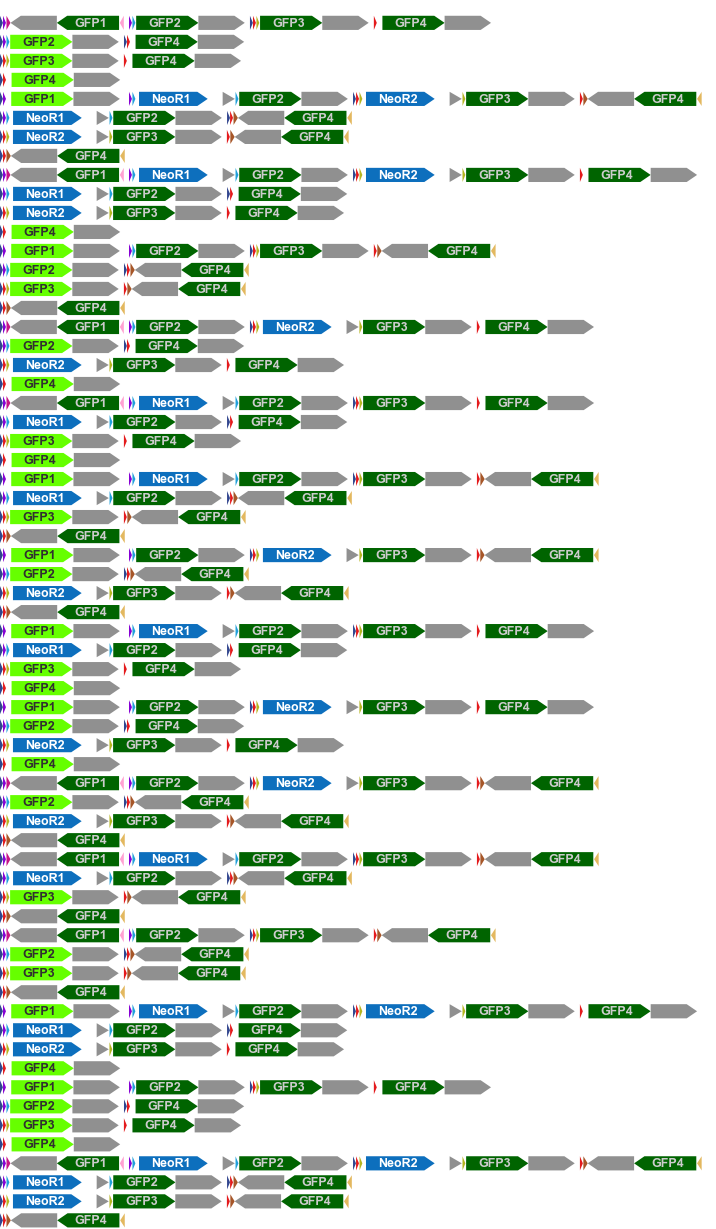

In [12]:

import matplotlib.pyplot as plt 
fig2 = plt.figure(figsize=(3,0.30))
for i, ax in enumerate(axes[::-1]):
    ax.remove()
    ax.figure = fig2 
    ax     = fig2.add_axes(ax)
    ax.set_label(i)
    pos    = ax.get_position()
    width  = abs(pos.x0-pos.x1)
    height = abs(pos.y0-pos.y1)
    ax.set_position([pos.x0, pos.y0+1.1*i*height, width, height])


In [13]:
fig2.savefig("output/LUT_all.pdf",bbox_inches="tight")

In [14]:
g = visualizeflow(gate_dict["OR"][3])
g.render("output/OR11_flow")

'output/OR11_flow.pdf'